<a href="https://colab.research.google.com/github/awenroberts/QM2-Project/blob/main/2awen_protests_visualisation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SPATIAL ANALYSIS

In [45]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pylab
from datetime import datetime

%matplotlib inline
pylab.rcParams['figure.figsize'] = (10, 8)

In [46]:
df = pd.read_excel("/content/Copy support-local-authority-datasets-sep-2025.xlsx",
                   sheet_name="2025",
                   engine='openpyxl')
df.head()

,event_id,date,location_name,town_city,postcode,description,wiki ref,source_url
0,U0011,2025-08-08,Hotel protest and counter-protest,Liverpool,L1 1JW,Two groups faced off at a hotel; some counter-...,124,https://news.sky.com/story/migrant-protesters-...
1,E0060,2025-09-06,Protest,Aberdeen,AB10 1BL,Arrest reported as protesters gathered.,193,https://www.pressandjournal.co.uk/fp/news/6845...
2,E0036,2025-08-02,Demonstration outside accommodation,Aberdeen,AB25 1XF,Arrests/charges under Hate Crime Act reported.,102,https://www.bbc.co.uk/news/articles/cy8jde62697o
3,E0004,2025-05-17,City centre march → Victoria Square,Birmingham,B1 1BD,Britain First supporters marched; council said...,49,https://www.birminghammail.co.uk/news/midlands...
4,E0048,2025-08-15,Asylum hotel protest,Sutton Coldfield,B76 1LH,Protest at asylum hotel reported.,136,https://www.birminghammail.co.uk/news/midlands...


In [47]:
import pandas as pd

xls = pd.ExcelFile("/content/Copy support-local-authority-datasets-sep-2025.xlsx")
print("Available Excel sheets:", xls.sheet_names)

Available Excel sheets: ['Cover_sheet', 'Contents', 'Notes', 'List_of_Fields', 'Asy_D11', 'Data_Asy_D11', 'Data_Asy_20242025', 'Data_Asy_2425', 'Data_Asy_D11_2020_2025', 'population_per_LA', 'la_exposure_table', 'la_exposure', 'la_exposure_table_old', '2025', 'protest_data', 'population for local authoritie']


In [48]:
!pip install pgeocode

import pgeocode
geo = pgeocode.Nominatim("gb")

In [49]:
df["postcode"] = (
    df["postcode"]
    .astype(str)
    .str.upper()
    .str.strip()
)

In [50]:
coords = df["postcode"].apply(geo.query_postal_code)

df["latitude"] = coords["latitude"]
df["longitude"] = coords["longitude"]

df.head()

,event_id,date,location_name,town_city,postcode,description,wiki ref,source_url,latitude,longitude
0,U0011,2025-08-08,Hotel protest and counter-protest,Liverpool,L1 1JW,Two groups faced off at a hotel; some counter-...,124,https://news.sky.com/story/migrant-protesters-...,53.41060,-2.977900
1,E0060,2025-09-06,Protest,Aberdeen,AB10 1BL,Arrest reported as protesters gathered.,193,https://www.pressandjournal.co.uk/fp/news/6845...,57.14370,-2.098100
2,E0036,2025-08-02,Demonstration outside accommodation,Aberdeen,AB25 1XF,Arrests/charges under Hate Crime Act reported.,102,https://www.bbc.co.uk/news/articles/cy8jde62697o,57.14370,-2.098100
3,E0004,2025-05-17,City centre march → Victoria Square,Birmingham,B1 1BD,Britain First supporters marched; council said...,49,https://www.birminghammail.co.uk/news/midlands...,52.48140,-1.899800
4,E0048,2025-08-15,Asylum hotel protest,Sutton Coldfield,B76 1LH,Protest at asylum hotel reported.,136,https://www.birminghammail.co.uk/news/midlands...,52.54015,-1.752717


In [51]:
df = df.dropna(subset=["latitude", "longitude"])
print("Remaining events:", len(df))


Remaining events: 126


In [52]:
city_coords = (
    df.groupby("town_city")[["latitude", "longitude"]]
      .mean()
      .reset_index()
)

city_coords.head()

,town_city,latitude,longitude
0,Aberdeen,57.14370,-2.098100
1,Altrincham,53.38524,-2.365540
2,Ashford,51.15110,0.890813
3,Barnwood (Gloucester),51.82706,-2.187810
4,Basingstoke,51.26250,-1.087100


In [53]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

In [54]:
import networkx as nx

G = nx.Graph()

# Add nodes with coordinates
for _, row in city_coords.iterrows():
    G.add_node(
        row["town_city"],
        lat=row["latitude"],
        lon=row["longitude"]
    )

In [55]:
threshold_km = 100

for i, r1 in city_coords.iterrows():
    for j, r2 in city_coords.iterrows():
        if i < j:
            d = haversine(
                r1.latitude, r1.longitude,
                r2.latitude, r2.longitude
            )
            if d <= threshold_km:
                G.add_edge(r1.town_city, r2.town_city, distance=d)

In [56]:
!rm /content/LAD_MAY_2025_UK_BFC_V2_481919774574330966 (1).geojson

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `rm /content/LAD_MAY_2025_UK_BFC_V2_481919774574330966 (1).geojson'


In [57]:
import geopandas as gpd

uk_map = gpd.read_file("/content/LAD_MAY_2025_UK_BFC_V2_481919774574330966.geojson")
uk_map.head()

,FID,LAD25CD,LAD25NM,LAD25NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,1,E06000001,Hartlepool,,447161,531473,-1.270174,54.676132,847f2c4b-a7cf-4c71-840c-0864853246d5,"MULTIPOLYGON (((-1.2247 54.62611, -1.22493 54...."
1,2,E06000002,Middlesbrough,,451141,516887,-1.210998,54.544679,f1925b75-6267-417d-a77a-05cdc4c6b1b3,"MULTIPOLYGON (((-1.2772 54.54784, -1.27721 54...."
2,3,E06000003,Redcar and Cleveland,,464330,519596,-1.006565,54.567520,36b1db27-3dfa-4ed6-8e81-36bf3abeeacc,"MULTIPOLYGON (((-1.20098 54.57763, -1.2003 54...."
3,4,E06000004,Stockton-on-Tees,,444940,518179,-1.306646,54.556876,22a6adf7-e812-4c09-89b1-6753ec35de93,"MULTIPOLYGON (((-1.27211 54.55337, -1.27213 54..."
4,5,E06000005,Darlington,,428029,515648,-1.568356,54.535345,309364b5-9b5c-4f9c-81f5-8a3a79699fd1,"POLYGON ((-1.63768 54.61714, -1.63767 54.6167,..."


In [58]:
!ls /content

'Copy support-local-authority-datasets-sep-2025.xlsx'   sample_data
 LAD_MAY_2025_UK_BFC_V2_481919774574330966.geojson


In [59]:
uk_map = uk_map.to_crs("EPSG:4326")

In [60]:
from shapely.geometry import Point
import pandas as pd

city_df = pd.DataFrame({
    "city": list(G.nodes()),
    "latitude": [G.nodes[n]["lat"] for n in G.nodes()],
    "longitude": [G.nodes[n]["lon"] for n in G.nodes()]
})

geometry = [Point(xy) for xy in zip(city_df["longitude"], city_df["latitude"])]
city_gdf = gpd.GeoDataFrame(city_df, geometry=geometry, crs="EPSG:4326")

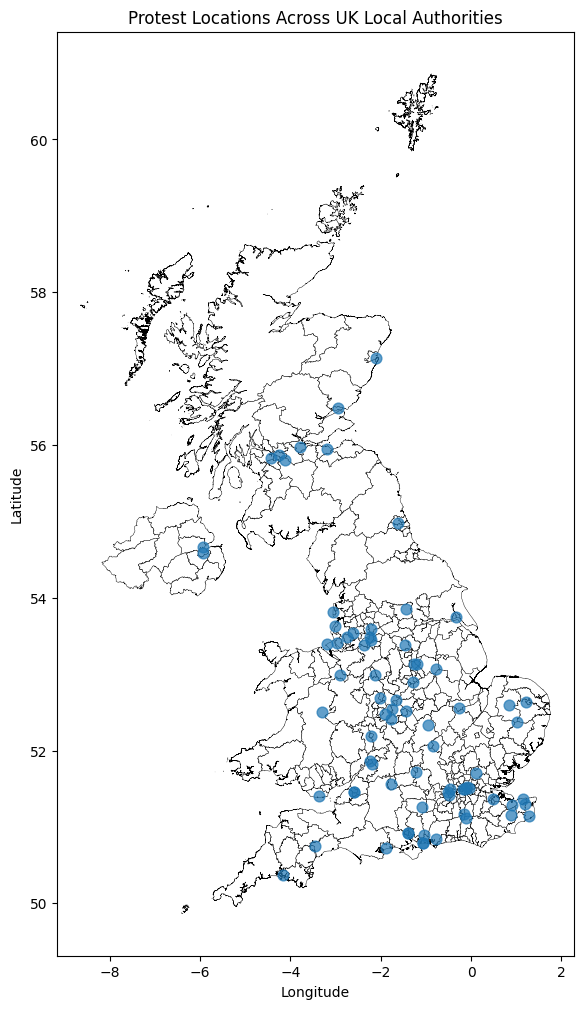

In [61]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))

# Plot local authority boundaries
uk_map.plot(
    ax=ax,
    color="white",
    edgecolor="black",
    linewidth=0.3
)

# Plot protest city points
city_gdf.plot(
    ax=ax,
    markersize=60,
    alpha=0.7
)

ax.set_title("Protest Locations Across UK Local Authorities")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [62]:
import geopandas as gpd
from shapely.geometry import Point

# Create geometry column from lat/lon
geometry = [Point(xy) for xy in zip(df["longitude"], df["latitude"])]

gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")


In [63]:
uk_map = uk_map.to_crs(epsg=4326)

In [64]:
gdf_with_la = gpd.sjoin(
    gdf,
    uk_map,
    how="left",
    predicate="within"
)

uk_map.columns

Index(['FID', 'LAD25CD', 'LAD25NM', 'LAD25NMW', 'BNG_E', 'BNG_N', 'LONG',
       'LAT', 'GlobalID', 'geometry'],
      dtype='object')

In [65]:
gdf_with_la["local_authority"] = gdf_with_la["LAD25NM"]

In [66]:
#gdf_with_la[["event_id", "town_city", "postcode", "local_authority", "LAD25CD"]].head()
protests_df = gdf_with_la[["event_id", "town_city", "postcode", "local_authority", "LAD25CD"]]

#rename the columns to make things easier later
protests_df = protests_df.rename(columns={
    "LAD25CD": "lad_code",
})

protests_df

,event_id,town_city,postcode,local_authority,lad_code
0,U0011,Liverpool,L1 1JW,Liverpool,E08000012
1,E0060,Aberdeen,AB10 1BL,Aberdeen City,S12000033
2,E0036,Aberdeen,AB25 1XF,Aberdeen City,S12000033
3,E0004,Birmingham,B1 1BD,Birmingham,E08000025
4,E0048,Sutton Coldfield,B76 1LH,Birmingham,E08000025
...,...,...,...,...,...
121,E0044,Altrincham,WA14 4DP,Trafford,E08000009
122,E0074,Wigan,WN1 1PE,Wigan,E08000010
123,E0050,Worcester,WR1 2AP,Worcester,E07000237
124,E0037,Cannock,WS11 1SH,Cannock Chase,E07000192


In [67]:
protests_df.dtypes

,0
event_id,object
town_city,object
postcode,object
local_authority,object
lad_code,object


In [68]:

#change the data types accordingly so we can work with the data usign pandas
protests_df['event_id']=protests_df['event_id'].astype('string')
protests_df['town_city']=protests_df['town_city'].astype('category')
protests_df['postcode']=protests_df['postcode'].astype('category')
protests_df['local_authority']=protests_df['local_authority'].astype('category')

In [69]:
import pandas as pd

xls = pd.ExcelFile("/content/Copy support-local-authority-datasets-sep-2025.xlsx")
print("Available Excel sheets:", xls.sheet_names)


pop_df = pd.read_excel(
    "/content/Copy support-local-authority-datasets-sep-2025.xlsx",
    sheet_name="population_per_LA", # Changed to include the trailing space
    header=0,
    engine="openpyxl"
)
pop_df.head()

Available Excel sheets: ['Cover_sheet', 'Contents', 'Notes', 'List_of_Fields', 'Asy_D11', 'Data_Asy_D11', 'Data_Asy_20242025', 'Data_Asy_2425', 'Data_Asy_D11_2020_2025', 'population_per_LA', 'la_exposure_table', 'la_exposure', 'la_exposure_table_old', '2025', 'protest_data', 'population for local authoritie']


,lad_code,name,geography,population,Isy
0,E06000047,County Durham,Unitary Authority,538011,True
1,E06000005,Darlington,Unitary Authority,112489,True
2,E06000001,Hartlepool,Unitary Authority,98180,True
3,E06000002,Middlesbrough,Unitary Authority,156161,True
4,E06000057,Northumberland,Unitary Authority,331420,True


In [70]:
pop_df.columns
pop_df["lad_code"].nunique()


354

In [71]:
la_exposure = pd.read_excel(
    "/content/Copy support-local-authority-datasets-sep-2025.xlsx",
    sheet_name="la_exposure",
    engine="openpyxl"
)
la_exposure.head()

,index,lad_code,local_authority,population,total_asylum_2025_cumulative,total_contingency,contingency_share_2025_cumulative,total_asylumQ3,contingency_per_1000,contingency_shareQ3,delta_contingency_Q1_Q3
0,338,N09000011,Ards and North Down,165415,131,131,1.0000,37,0.2237,1.0000,-16
1,206,E07000221,Stratford-on-Avon,146258,333,332,0.9970,138,0.9435,1.0000,55
2,238,E07000040,East Devon,158239,653,650,0.9954,269,1.7000,1.0000,82
3,271,S12000006,Dumfries and Galloway,145860,281,279,0.9929,107,0.7336,1.0000,38
4,43,S12000040,West Lothian,186440,257,255,0.9922,89,0.4720,0.9888,9


In [72]:
uk_map = uk_map.merge(
    la_exposure,
    left_on="LAD25NM",
    right_on="local_authority",
    how="left"
)

uk_map[["local_authority", "total_asylum_2025_cumulative", "total_contingency", "contingency_share_2025_cumulative", "total_asylumQ3", "contingency_shareQ3", "contingency_per_1000", "delta_contingency_Q1_Q3"]].head()

,local_authority,total_asylum_2025_cumulative,total_contingency,contingency_share_2025_cumulative,total_asylumQ3,contingency_shareQ3,contingency_per_1000,delta_contingency_Q1_Q3
0,Hartlepool,1314.0,0.0,0.0000,431.0,0.0000,0.0000,0.0
1,Middlesbrough,2094.0,0.0,0.0000,673.0,0.0000,0.0000,0.0
2,Redcar and Cleveland,777.0,0.0,0.0000,254.0,0.0000,0.0000,0.0
3,Stockton-on-Tees,2384.0,68.0,0.0285,805.0,0.0385,0.1499,12.0
4,Darlington,675.0,0.0,0.0000,220.0,0.0000,0.0000,0.0


In [73]:
map_codes = set(uk_map["LAD25CD"])
data_codes = set(la_exposure["lad_code"])

print("Map authorities:", len(map_codes))
print("Data authorities:", len(data_codes))
print("Matching authorities:", len(map_codes & data_codes))

Map authorities: 361
Data authorities: 345
Matching authorities: 343


In [74]:
map_with_data = uk_map[uk_map["contingency_share_2025_cumulative"].notna()]

#MAP SPATIAL PLOTS

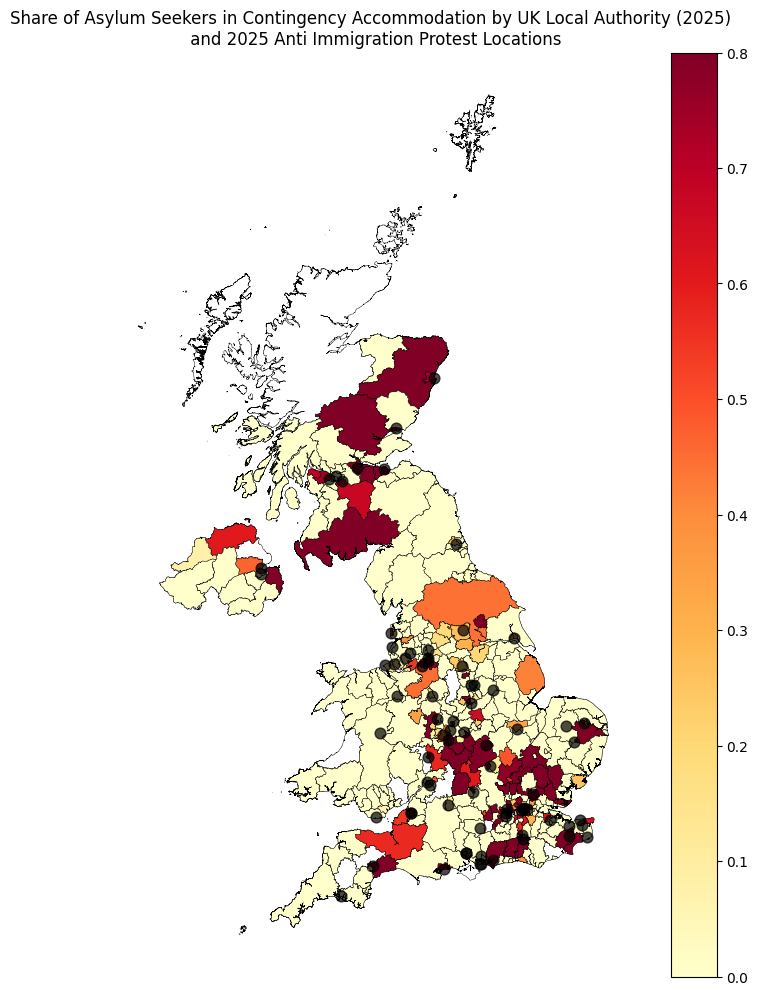

In [75]:
#map 1: share in contingency - culmative over 2025
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))

uk_map.plot(
    ax=ax,
    color="white",
    edgecolor="black",
    linewidth=0.3
)


map_with_data.plot(
    column="contingency_share_2025_cumulative",
    cmap="YlOrRd",
    legend=True,
    linewidth=0.3,
    edgecolor="black",
     vmin=0,
    vmax=0.8,
    ax=ax
)

city_gdf.plot(
    ax=ax,
    markersize=60,
    color="black",
    alpha=0.7
)

ax.set_title("Share of Asylum Seekers in Contingency Accommodation by UK Local Authority (2025) \n and 2025 Anti Immigration Protest Locations")
ax.axis("off")

plt.show()

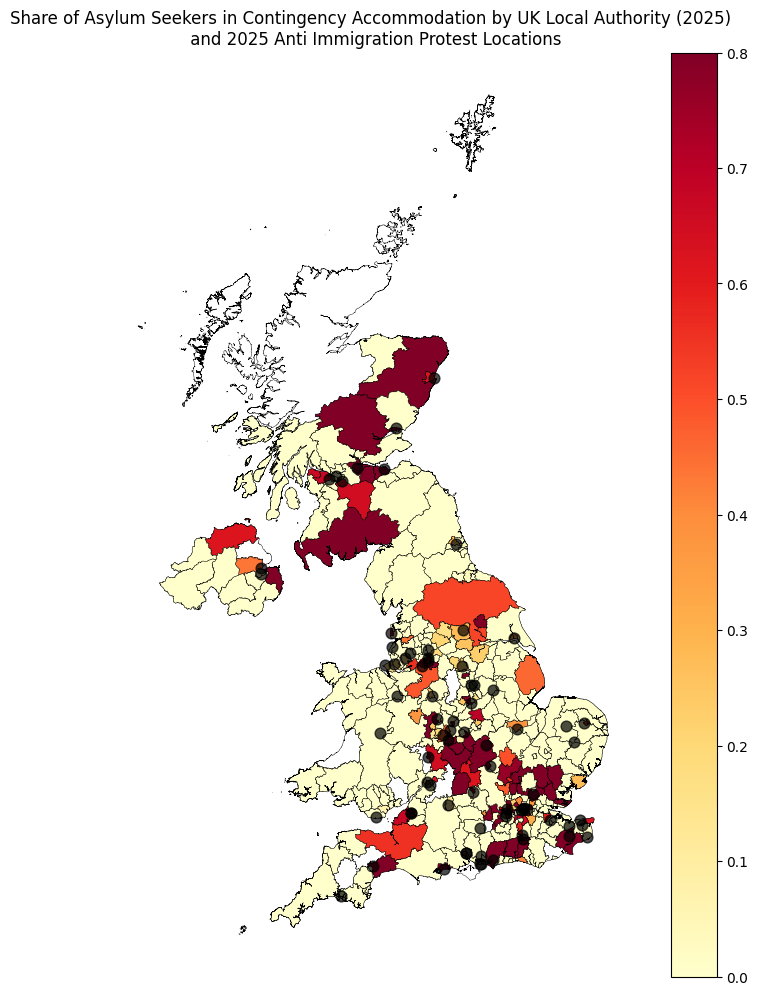

In [76]:
#map 2: share in contingency - Q3 2025
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))

uk_map.plot(
    ax=ax,
    color="white",
    edgecolor="black",
    linewidth=0.3
)


map_with_data.plot(
    column="contingency_shareQ3",
    cmap="YlOrRd",
    legend=True,
    linewidth=0.3,
    edgecolor="black",
     vmin=0,
    vmax=0.8,
    ax=ax
)

city_gdf.plot(
    ax=ax,
    markersize=60,
    color="black",
    alpha=0.7
)

ax.set_title("Share of Asylum Seekers in Contingency Accommodation by UK Local Authority (2025) \n and 2025 Anti Immigration Protest Locations")
ax.axis("off")


plt.show()

(np.float64(-9.1706809054527),
 np.float64(2.2843906818119115),
 np.float64(49.314862230815606),
 np.float64(61.41059332761429))

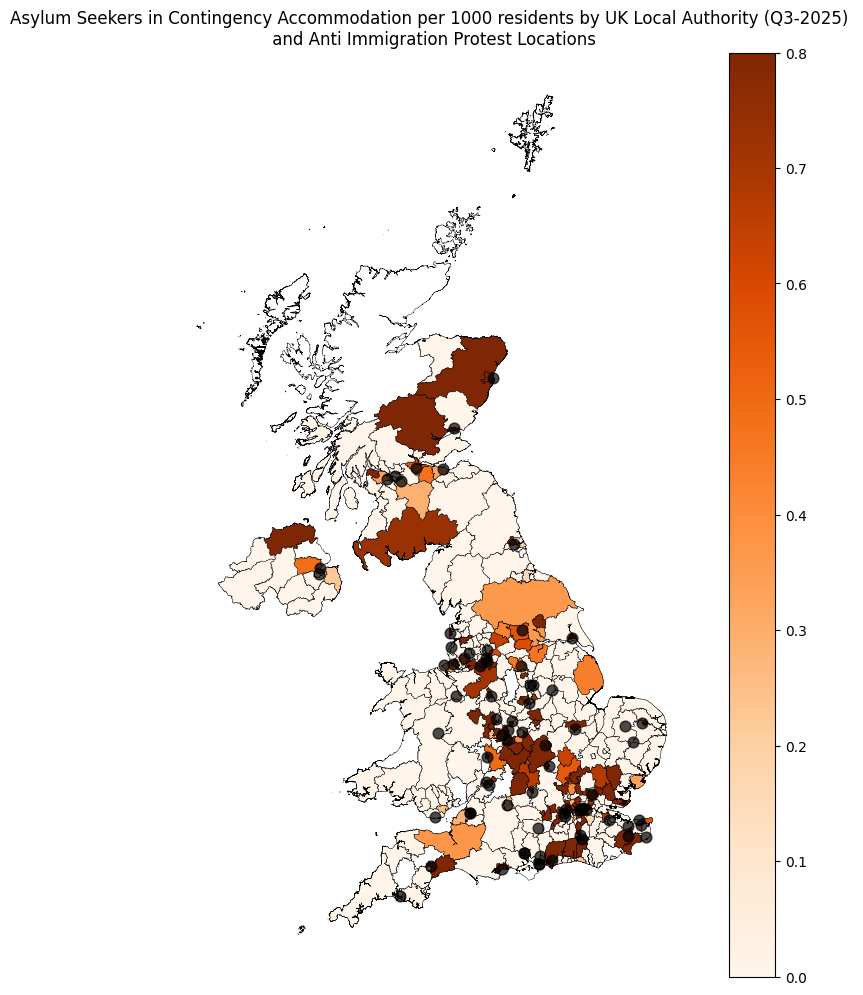

In [77]:
#map 3: contingency per 1000 residents - Q3 2025
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))

uk_map.plot(
    ax=ax,
    color="white",
    edgecolor="black",
    linewidth=0.3
)


map_with_data.plot(
    column="contingency_per_1000",
    cmap="Oranges",
    legend=True,
    linewidth=0.3,
    edgecolor="black",
     vmin=0,
    vmax=0.8,
    ax=ax
)

city_gdf.plot(
    ax=ax,
    markersize=60,
    color="black",
    alpha=0.7
)

ax.set_title("Asylum Seekers in Contingency Accommodation per 1000 residents by UK Local Authority (Q3-2025) \n and Anti Immigration Protest Locations")
ax.axis("off")


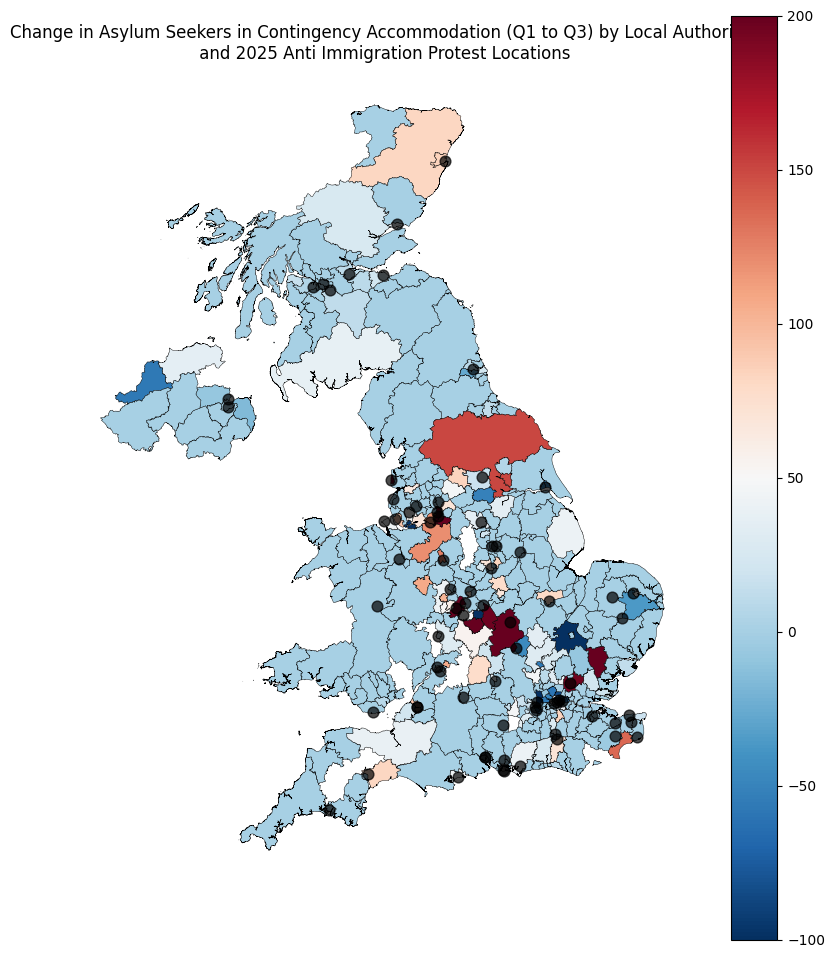

In [78]:
#map 4: change in number of asylum seekers in contingency accomodation from Q1 to Q3 2025
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

uk_map.plot(
    column="delta_contingency_Q1_Q3",
    cmap="RdBu_r",
    linewidth=0.3,
    edgecolor="black",
    legend=True,
     vmin=-100,
    vmax=200,
    ax=ax
)

city_gdf.plot(
    ax=ax,
    markersize=60,
    color="black",
    alpha=0.7
)

ax.set_title("Change in Asylum Seekers in Contingency Accommodation (Q1 to Q3) by Local Authority \n and 2025 Anti Immigration Protest Locations")
ax.axis("off")

plt.show()


##NEW SIMPLER CODE

In [79]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point


In [80]:
xlsx_path = "/content/Copy support-local-authority-datasets-sep-2025.xlsx"

raw_2025 = pd.read_excel(xlsx_path, sheet_name="2025", engine="openpyxl")
protests_tab = pd.read_excel(xlsx_path, sheet_name="protest_data", engine="openpyxl")
la_exposure = pd.read_excel(xlsx_path, sheet_name="la_exposure", engine="openpyxl")


In [81]:
# Add LA centroid geometry to each LAD code
la_centroids = uk_map[["LAD25CD", "geometry"]].copy()
la_centroids["geometry"] = la_centroids.geometry.centroid  # points
la_centroids = la_centroids.rename(columns={"LAD25CD": "lad_code"})

# Merge centroid geometry onto protest events using lad_code
protests_df = protests_tab.merge(
    la_centroids,
    on="lad_code",
    how="left"
)

# Convert to GeoDataFrame
protests_gdf = gpd.GeoDataFrame(protests_df, geometry="geometry", crs="EPSG:4326")
protests_gdf

/tmp/ipython-input-1229578465.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  la_centroids["geometry"] = la_centroids.geometry.centroid  # points


,index,event_id,town_city,postcode,local_authority,lad_code,date,year_quarter,geometry
0,0,U0011,Liverpool,L1 1JW,Liverpool,E08000012,2025-08-08,2025Q3,POINT (-2.91669 53.40395)
1,1,E0060,Aberdeen,AB10 1BL,Aberdeen City,S12000033,2025-09-06,2025Q3,POINT (-2.18685 57.15713)
2,2,E0036,Aberdeen,AB25 1XF,Aberdeen City,S12000033,2025-08-02,2025Q3,POINT (-2.18685 57.15713)
3,3,E0004,Birmingham,B1 1BD,Birmingham,E08000025,2025-05-17,2025Q2,POINT (-1.87471 52.48861)
4,4,E0048,Sutton Coldfield,B76 1LH,Birmingham,E08000025,2025-08-15,2025Q3,POINT (-1.87471 52.48861)
...,...,...,...,...,...,...,...,...,...
121,121,E0044,Altrincham,WA14 4DP,Trafford,E08000009,2025-08-08,2025Q3,POINT (-2.35533 53.41903)
122,122,E0074,Wigan,WN1 1PE,Wigan,E08000010,2025-09-27,2025Q3,POINT (-2.58957 53.52417)
123,123,E0050,Worcester,WR1 2AP,Worcester,E07000237,2025-08-20,2025Q3,POINT (-2.21123 52.1967)
124,124,E0037,Cannock,WS11 1SH,Cannock Chase,E07000192,2025-08-02,2025Q3,POINT (-1.98021 52.71243)


In [82]:
map_with_data = uk_map.merge(
    la_exposure,
    left_on="LAD25CD",
    right_on="lad_code",
    how="left"
)


In [83]:
print("LAs in map:", len(uk_map))
print("LAs matched to exposure:", map_with_data["contingency_share_2025_cumulative_y"].notna().sum())
print("Protest events:", len(protests_gdf))
print("Protest events with geometry:", protests_gdf["geometry"].notna().sum())

LAs in map: 368
LAs matched to exposure: 361
Protest events: 126
Protest events with geometry: 125


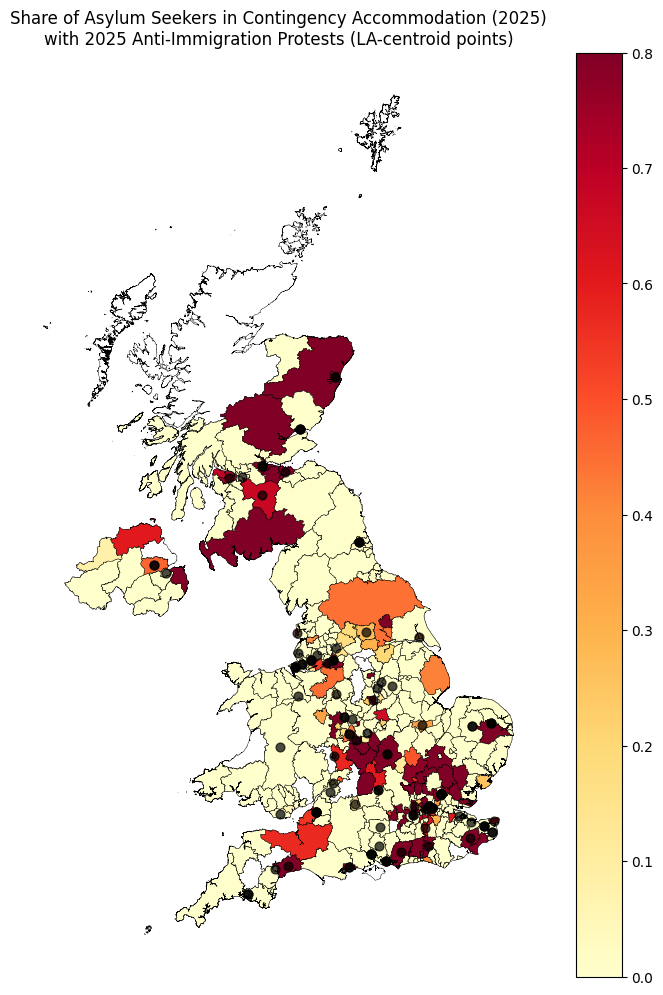

In [44]:
fig, ax = plt.subplots(figsize=(10, 12))

# Outline layer (optional, but nice)
uk_map.plot(ax=ax, color="white", edgecolor="black", linewidth=0.3)

# Choropleth layer
map_with_data.plot(
    ax=ax,
    column="contingency_share_2025_cumulative_y",
    cmap="YlOrRd",
    legend=True,
    linewidth=0.3,
    edgecolor="black",
    vmin=0,
    vmax=0.8
)

# Protest points (centroids)
protests_gdf.plot(
    ax=ax,
    markersize=40,
    color="black",
    alpha=0.7
)

ax.set_title(
    "Share of Asylum Seekers in Contingency Accommodation (2025)\nwith 2025 Anti-Immigration Protests (LA-centroid points)"
)
ax.axis("off")

plt.show()


In [84]:
protests_counts = (
    protests_tab
    .groupby(["lad_code", "local_authority"])
    .size()
    .reset_index(name="protests_count")
)


In [85]:
analysis_df = la_exposure.merge(
    protests_counts[["lad_code", "protests_count"]],
    on="lad_code",
    how="left"
)

analysis_df["protests_count"] = analysis_df["protests_count"].fillna(0)
analysis_df["any_protest"] = (analysis_df["protests_count"] > 0).astype(int)

analysis_df.head()


,index,lad_code,local_authority,population,total_asylum_2025_cumulative,total_contingency,contingency_share_2025_cumulative,total_asylumQ3,contingency_per_1000,contingency_shareQ3,delta_contingency_Q1_Q3,protests_count,any_protest
0,338,N09000011,Ards and North Down,165415,131,131,1.0000,37,0.2237,1.0000,-16,0.0,0
1,206,E07000221,Stratford-on-Avon,146258,333,332,0.9970,138,0.9435,1.0000,55,0.0,0
2,238,E07000040,East Devon,158239,653,650,0.9954,269,1.7000,1.0000,82,1.0,1
3,271,S12000006,Dumfries and Galloway,145860,281,279,0.9929,107,0.7336,1.0000,38,0.0,0
4,43,S12000040,West Lothian,186440,257,255,0.9922,89,0.4720,0.9888,9,0.0,0


In [86]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Work on a projected CRS (distances in metres)
la_polys = map_with_data.to_crs("EPSG:27700")  # British National Grid

# Use centroids for distance calculations
la_polys["centroid"] = la_polys.geometry.centroid

coords = np.column_stack([
    la_polys["centroid"].x,
    la_polys["centroid"].y
])

# Choose number of neighbours (5 neighbours + itself = 6)
k = 6
nbrs = NearestNeighbors(n_neighbors=k).fit(coords)
distances, indices = nbrs.kneighbors(coords)

# Column to smooth
col = "contingency_share_2025_cumulative_y"

# Compute neighbour-average (exclude itself)
la_polys["contingency_share_smoothed"] = [
    la_polys.iloc[idx[1:]][col].mean()
    for idx in indices
]

# Return to lat/long for plotting
map_with_data = la_polys.to_crs("EPSG:4326")


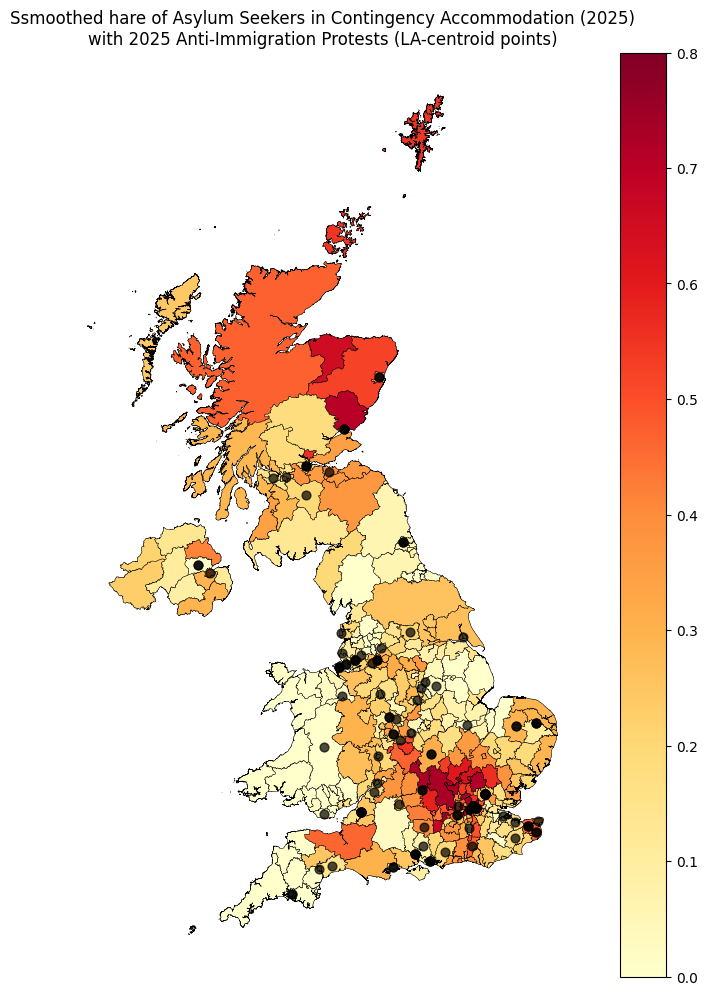

In [89]:
fig, ax = plt.subplots(figsize=(10, 12))

# Outline layer (optional, but nice)
uk_map.plot(ax=ax, color="white", edgecolor="black", linewidth=0.3)

# Choropleth layer
map_with_data.plot(
    ax=ax,
    column="contingency_share_smoothed",
    cmap="YlOrRd",
    legend=True,
    linewidth=0.3,
    edgecolor="black",
    vmin=0,
    vmax=0.8
)

# Protest points (centroids)
protests_gdf.plot(
    ax=ax,
    markersize=40,
    color="black",
    alpha=0.7
)

ax.set_title(
    "Ssmoothed hare of Asylum Seekers in Contingency Accommodation (2025)\nwith 2025 Anti-Immigration Protests (LA-centroid points)"
)
ax.axis("off")

plt.show()


In [91]:
analysis_df = analysis_df.merge(
    map_with_data[["lad_code_y", "contingency_share_smoothed"]],
    left_on="lad_code",
    right_on="lad_code_y",
    how="left"
)
analysis_df[[
    "contingency_share_2025_cumulative",
    "contingency_share_smoothed"
]].corr()

,contingency_share_2025_cumulative,contingency_share_smoothed
contingency_share_2025_cumulative,1.000000,0.422442
contingency_share_smoothed,0.422442,1.000000


In [92]:
sns.boxplot(
    x="any_protest",
    y="contingency_share_smoothed",
    data=analysis_df
)


NameError: name 'sns' is not defined